<a href="https://colab.research.google.com/github/jdz014/DS-Unit-2-Applied-Modeling/blob/master/module4-model-interpretation/LS_DS12_234_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


Lambda School Data Science

*Unit 2, Sprint 3, Module 4*

---

# Model Interpretation

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [ ] Continue to iterate on your project: data cleaning, exploratory visualization, feature engineering, modeling.
- [ ] Make at least 1 partial dependence plot to explain your model.
- [ ] Make at least 1 Shapley force plot to explain an individual prediction.
- [ ] **Share at least 1 visualization (of any type) on Slack!**

If you aren't ready to make these plots with your own dataset, you can practice these objectives with any dataset you've worked with previously. Example solutions are available for Partial Dependence Plots with the Tanzania Waterpumps dataset, and Shapley force plots with the Titanic dataset. (These datasets are available in the data directory of this repository.)

Please be aware that **multi-class classification** will result in multiple Partial Dependence Plots (one for each class), and multiple sets of Shapley Values (one for each class).

## Stretch Goals

#### Partial Dependence Plots
- [ ] Make multiple PDPs with 1 feature in isolation.
- [ ] Make multiple PDPs with 2 features in interaction. 
- [ ] Use Plotly to make a 3D PDP.
- [ ] Make PDPs with categorical feature(s). Use Ordinal Encoder, outside of a pipeline, to encode your data first. If there is a natural ordering, then take the time to encode it that way, instead of random integers. Then use the encoded data with pdpbox. Get readable category names on your plot, instead of integer category codes.

#### Shap Values
- [ ] Make Shapley force plots to explain at least 4 individual predictions.
    - If your project is Binary Classification, you can do a True Positive, True Negative, False Positive, False Negative.
    - If your project is Regression, you can do a high prediction with low error, a low prediction with low error, a high prediction with high error, and a low prediction with high error.
- [ ] Use Shapley values to display verbal explanations of individual predictions.
- [ ] Use the SHAP library for other visualization types.

The [SHAP repo](https://github.com/slundberg/shap) has examples for many visualization types, including:

- Force Plot, individual predictions
- Force Plot, multiple predictions
- Dependence Plot
- Summary Plot
- Summary Plot, Bar
- Interaction Values
- Decision Plots

We just did the first type during the lesson. The [Kaggle microcourse](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values) shows two more. Experiment and see what you can learn!

### Links

#### Partial Dependence Plots
- [Kaggle / Dan Becker: Machine Learning Explainability — Partial Dependence Plots](https://www.kaggle.com/dansbecker/partial-plots)
- [Christoph Molnar: Interpretable Machine Learning — Partial Dependence Plots](https://christophm.github.io/interpretable-ml-book/pdp.html) + [animated explanation](https://twitter.com/ChristophMolnar/status/1066398522608635904)
- [pdpbox repo](https://github.com/SauceCat/PDPbox) & [docs](https://pdpbox.readthedocs.io/en/latest/)
- [Plotly: 3D PDP example](https://plot.ly/scikit-learn/plot-partial-dependence/#partial-dependence-of-house-value-on-median-age-and-average-occupancy)

#### Shapley Values
- [Kaggle / Dan Becker: Machine Learning Explainability — SHAP Values](https://www.kaggle.com/learn/machine-learning-explainability)
- [Christoph Molnar: Interpretable Machine Learning — Shapley Values](https://christophm.github.io/interpretable-ml-book/shapley.html)
- [SHAP repo](https://github.com/slundberg/shap) & [docs](https://shap.readthedocs.io/en/latest/)

In [0]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pdpbox
    !pip install shap

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
!wget 'https://raw.githubusercontent.com/washingtonpost/data-school-shootings/master/school-shootings-data.csv'

--2020-02-28 18:20:04--  https://raw.githubusercontent.com/washingtonpost/data-school-shootings/master/school-shootings-data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70530 (69K) [text/plain]
Saving to: ‘school-shootings-data.csv’

school-shootings-da 100%[===================>]  68.88K  --.-KB/s    in 0.02s   

2020-02-28 18:20:04 (2.76 MB/s) - ‘school-shootings-data.csv’ saved [70530/70530]



In [3]:
import pandas as pd

df = pd.read_csv('school-shootings-data.csv')
print(df.shape)
df.head()

(238, 50)


,uid,nces_school_id,school_name,nces_district_id,district_name,date,school_year,year,time,day_of_week,city,state,school_type,enrollment,killed,injured,casualties,shooting_type,age_shooter1,gender_shooter1,race_ethnicity_shooter1,shooter_relationship1,shooter_deceased1,deceased_notes1,age_shooter2,gender_shooter2,race_ethnicity_shooter2,shooter_relationship2,shooter_deceased2,deceased_notes2,white,black,hispanic,asian,american_indian_alaska_native,hawaiian_native_pacific_islander,two_or_more,resource_officer,weapon,weapon_source,lat,long,staffing,low_grade,high_grade,lunch,county,state_fips,county_fips,ulocale
0,1,080480000707,Columbine High School,804800.0,Jefferson County R-1,4/20/1999,1998-1999,1999,11:19 AM,Tuesday,Littleton,Colorado,public,1965,13,21,34,indiscriminate,18.0,m,w,student,1.0,suicide,17.0,m,w,student,1.0,suicide,1783,16.0,112.0,42.0,12.0,NaN,NaN,1,12-gauge Savage-Springfield 67H pump-action sh...,purchased from friends,39.603910,-105.075000,89.6,9,12,41.0,Jefferson County,8,8059,21.0
1,2,220054000422,Scotlandville Middle School,2200540.0,East Baton Rouge Parish School Board,4/22/1999,1998-1999,1999,12:30 PM,Thursday,Baton Rouge,Louisiana,public,588,0,1,1,targeted,14.0,m,NaN,former student (expelled),0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5,583.0,0.0,0.0,0.0,NaN,NaN,0,.22-caliber handgun,NaN,30.529958,-91.169966,39.0,6,8,495.0,East Baton Rouge Parish,22,22033,12.0
2,3,130441001591,Heritage High School,1304410.0,Rockdale County,5/20/1999,1998-1999,1999,8:03 AM,Thursday,Conyers,Georgia,public,"1,369",0,6,6,indiscriminate,15.0,m,w,student,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1189,136.0,28.0,15.0,1.0,NaN,NaN,1,".22-caliber rifle, .357-caliber Magnum handgun",NaN,33.626922,-84.047960,84.0,9,12,125.0,Rockdale County,13,13247,21.0
3,4,421899003847,John Bartram High School,4218990.0,Philadelphia City SD,10/4/1999,1999-2000,1999,10:00 AM,Monday,Philadelphia,Pennsylvania,public,3147,0,1,1,targeted,17.0,m,NaN,student,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,209,2736.0,27.0,170.0,5.0,NaN,NaN,1,RG .25-caliber handgun,purchased from friend,39.921509,-75.234108,41.0,9,12,2007.0,Philadelphia County,42,42101,11.0
4,5,250279000225,Dorchester High School,2502790.0,Boston,11/3/1999,1999-2000,1999,7:40 AM,Wednesday,Boston,Massachusetts,public,"1,116",0,1,1,targeted,NaN,m,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40,755.0,287.0,29.0,5.0,NaN,NaN,0,NaN,NaN,42.285268,-71.075901,NaN,9,12,543.0,Suffolk County,25,25025,11.0


In [0]:
# Replace shooting type with 'other' for rows not 'targeted' or 'indiscriminate'
  df['shooting_type'] = df['shooting_type'].replace(['accidental', 'unclear',
                                                    'targeted and indiscriminate',
                                                    'public suicide',
                                                    'hostage suicide',
                                                    'accidental or targeted',
                                                    'public suicide (attempted)'],
                                                    'other')

# Fill missing value with 'other'
  df['shooting_type'] = df['shooting_type'].fillna('other')

In [5]:
# Majority class baseline 59%
df['shooting_type'].value_counts(normalize=True)

targeted          0.588235
other             0.222689
indiscriminate    0.189076
Name: shooting_type, dtype: float64

In [6]:
from sklearn.model_selection import train_test_split

# Create train, test
train, test = train_test_split(df, train_size=0.80, random_state=21, stratify=df['shooting_type'])

train.shape, test.shape

((190, 50), (48, 50))

In [7]:
def wrangle(df):

  # Avoid SettingWithCopyWarning
  df = df.copy()

  # Remove commas from numbers
  df['white'] = df['white'].str.replace(",", "")

  # Change from object to int
  df['white'] = pd.to_numeric(df['white'])
  
  # Remove commas from numbers
  df['enrollment'] = df['enrollment'].str.replace(",", "")

  # Change from object to int
  df['enrollment'] = pd.to_numeric(df['enrollment'])

  # Fill missing values for these specific columns
  df.fillna({'white': 0, 'black': 0, 'hispanic': 0, 'asian': 0,
           'american_indian_alaska_native': 0,
           'hawaiian_native_pacific_islander': 0, 'two_or_more': 0,
           'district_name': 'Unknown', 'time': '12:00 PM', 'lat': 33.612910,
           'long': -86.682000, 'staffing': 60.42, 'low_grade': '9',
           'high_grade': '12'}, inplace=True)
  
  # Drop columns with 200+ missing values
  df = df.drop(columns=['deceased_notes1', 'age_shooter2', 'gender_shooter2', 
                        'race_ethnicity_shooter2', 'shooter_relationship2', 
                        'shooter_deceased2', 'deceased_notes2'])

  # Drop unusable variance 
  df = df.drop(columns=['uid', 'nces_school_id', 'nces_district_id', 'weapon', 
                        'weapon_source', 'state_fips', 'county_fips', 'ulocale',
                        'lunch', 'age_shooter1', 'gender_shooter1',
                        'race_ethnicity_shooter1', 'shooter_relationship1',
                        'shooter_deceased1'])
  
  # Change date to datettime
  df['date'] = pd.to_datetime(df['date'])

  return df

train = wrangle(train)
test = wrangle(test)

train.shape, test.shape

((190, 29), (48, 29))

In [0]:
target = 'shooting_type'
features = train.columns.drop([target, 'date'])
X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [9]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline

pipeline = make_pipeline(
    ce.OrdinalEncoder(),  
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

# Fit on train, score on test
pipeline.fit(X_train, y_train)
print('Test Accuracy', pipeline.score(X_test, y_test))

Test Accuracy 0.5625


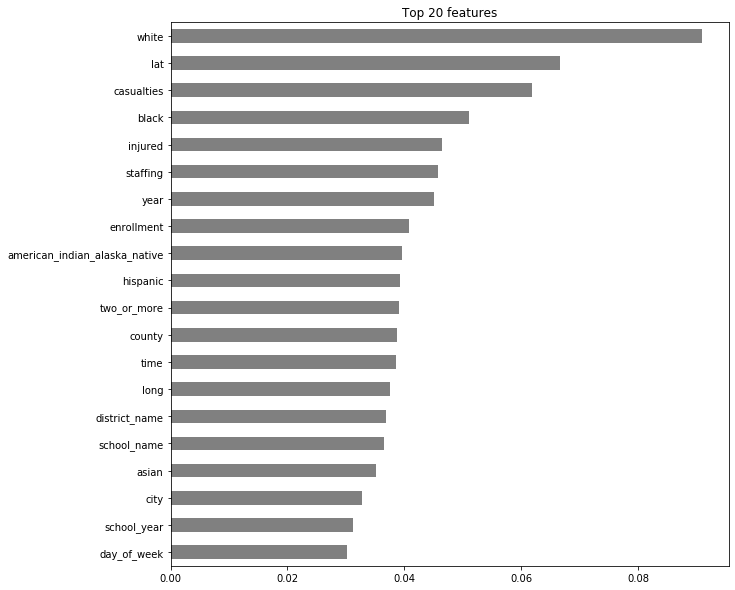

In [10]:
# Get feature importances
rf = pipeline.named_steps['randomforestclassifier']
importances = pd.Series(rf.feature_importances_, X_train.columns)

# Plot feature importances
%matplotlib inline
import matplotlib.pyplot as plt

n = 20
plt.figure(figsize=(10,n/2))
plt.title(f'Top {n} features')
importances.sort_values()[-n:].plot.barh(color='grey');

In [11]:
transformers = make_pipeline(
    ce.OrdinalEncoder())

X_train_transformed = transformers.fit_transform(X_train)

model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [12]:
import eli5
from eli5.sklearn import PermutationImportance

permuter = PermutationImportance(
    model, 
    scoring='accuracy', 
    n_iter=5, 
    random_state=42
)

permuter.fit(X_train_transformed, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.scorer module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.feature_selection.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.feature_selection. Anything that cannot be imported from sklearn.feature_selection is now part of the private API.
  warnings.warn(message, FutureWarning)
Using TensorFlow backend.


PermutationImportance(cv='prefit',
                      estimator=RandomForestClassifier(bootstrap=True,
                                                       ccp_alpha=0.0,
                                                       class_weight=None,
                                                       criterion='gini',
                                                       max_depth=None,
                                                       max_features='auto',
                                                       max_leaf_nodes=None,
                                                       max_samples=None,
                                                       min_impurity_decrease=0.0,
                                                       min_impurity_split=None,
                                                       min_samples_leaf=1,
                                                       min_samples_split=2,
                                                       min_weight_fr

In [13]:
feature_names = X_train.columns.tolist()
eli5.show_weights(
    permuter, 
    top=None,
    feature_names=feature_names)

Weight,Feature
0.0526 ± 0.0305,white
0.0137 ± 0.0052,lat
0.0084 ± 0.0052,year
0.0063 ± 0.0079,county
0.0053 ± 0.0000,casualties
0.0053 ± 0.0067,staffing
0.0053 ± 0.0000,hispanic
0.0053 ± 0.0067,black
0.0032 ± 0.0052,injured
0.0032 ± 0.0052,school_year


In [14]:
X_train.shape

(190, 27)

In [0]:
minimum_importance = 0
mask = permuter.feature_importances_ > minimum_importance
features = X_train.columns[mask]
X_train = X_train[features]
X_test = X_test[features]

In [16]:
# Dropped another 13 columns
X_train.shape, X_test.shape

((190, 14), (48, 14))

In [17]:
from xgboost import XGBClassifier

pipeline = make_pipeline(
    ce.OrdinalEncoder(), 
    XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['school_name', 'school_year', 'time',
                                      'day_of_week', 'county'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'school_name',
                                          'data_type': dtype('O'),
                                          'mapping': Fort Gibson Middle School         1
Simonsdale Elementary School      2
St. James Catholic School         3
Dorchester High School            4...
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, learning_rate=0.1,
                               max_delta_step=0, max_depth=3,
                               min_child_weight=1, missing=N

In [18]:
# The score will be worse, but haven't tuned hyperparameters yet
from sklearn.metrics import accuracy_score
y_pred = pipeline.predict(X_test)
print('Test Accuracy', accuracy_score(y_test, y_pred))

Test Accuracy 0.5


In [19]:
encoder = ce.OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_train)
X_test_encoded = encoder.transform(X_test)

model = XGBClassifier(
    n_estimators=1000, 
    max_depth=7,       
    learning_rate=0.5, 
    n_jobs=-1
)

eval_set = [(X_train_encoded, y_train),
            (X_test_encoded, y_test)]

model.fit(X_train_encoded, y_train, 
          eval_set=eval_set, 
          eval_metric='merror', 
          early_stopping_rounds=50)

[0]	validation_0-merror:0.068421	validation_1-merror:0.5
Multiple eval metrics have been passed: 'validation_1-merror' will be used for early stopping.

Will train until validation_1-merror hasn't improved in 50 rounds.
[1]	validation_0-merror:0.036842	validation_1-merror:0.458333
[2]	validation_0-merror:0.021053	validation_1-merror:0.541667
[3]	validation_0-merror:0	validation_1-merror:0.541667
[4]	validation_0-merror:0	validation_1-merror:0.5
[5]	validation_0-merror:0	validation_1-merror:0.520833
[6]	validation_0-merror:0	validation_1-merror:0.520833
[7]	validation_0-merror:0	validation_1-merror:0.520833
[8]	validation_0-merror:0	validation_1-merror:0.5
[9]	validation_0-merror:0	validation_1-merror:0.5
[10]	validation_0-merror:0	validation_1-merror:0.520833
[11]	validation_0-merror:0	validation_1-merror:0.458333
[12]	validation_0-merror:0	validation_1-merror:0.458333
[13]	validation_0-merror:0	validation_1-merror:0.479167
[14]	validation_0-merror:0	validation_1-merror:0.479167
[15]	v

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.5, max_delta_step=0, max_depth=7,
              min_child_weight=1, missing=None, n_estimators=1000, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

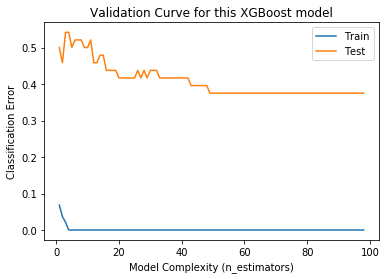

In [20]:
results = model.evals_result()
train_error = results['validation_0']['merror']
val_error = results['validation_1']['merror']
epoch = list(range(1, len(train_error)+1))
plt.plot(epoch, train_error, label='Train')
plt.plot(epoch, val_error, label='Test')
plt.ylabel('Classification Error')
plt.xlabel('Model Complexity (n_estimators)')
plt.title('Validation Curve for this XGBoost model')
#plt.ylim((0.35, 0.6)) # Zoom in
plt.legend();

In [0]:
import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 72

In [0]:
from pdpbox.pdp import pdp_isolate, pdp_plot

feature = 'white'

isolated = pdp_isolate(
    model=pipeline, 
    dataset=X_test, 
    model_features=X_test.columns, 
    feature=feature
)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


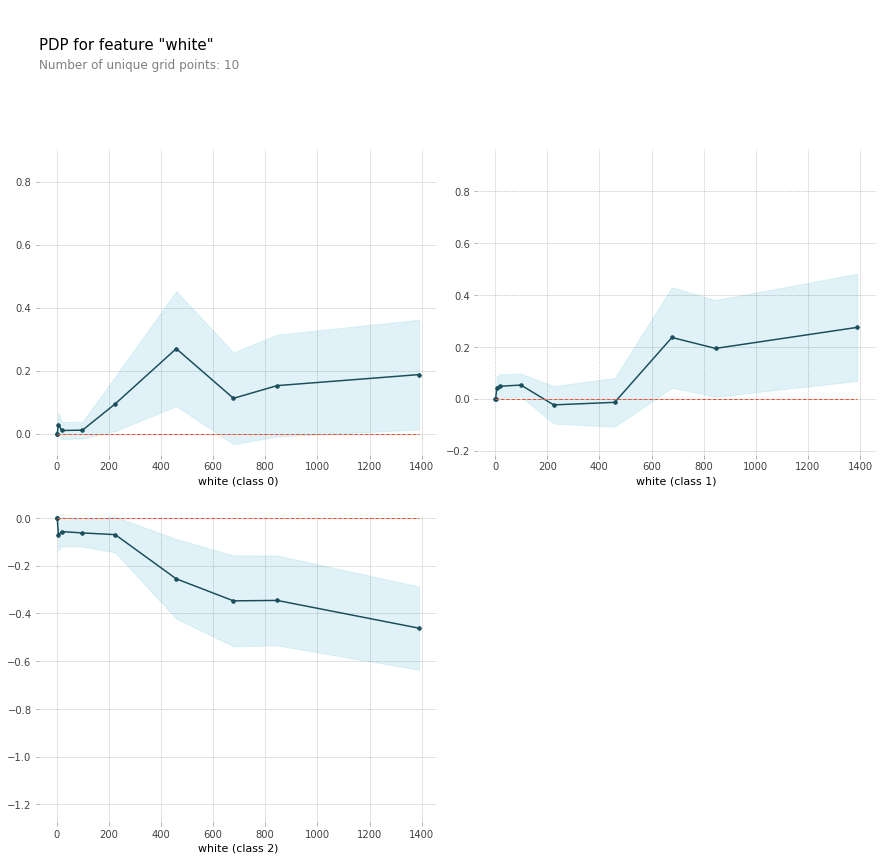

In [24]:
pdp_plot(isolated, feature_name=feature);

In [0]:
from pdpbox.pdp import pdp_interact, pdp_interact_plot

features = ['white', 'casualties']

interaction = pdp_interact(
    model=pipeline, 
    dataset=X_test, 
    model_features=X_test.columns,
    features=features)

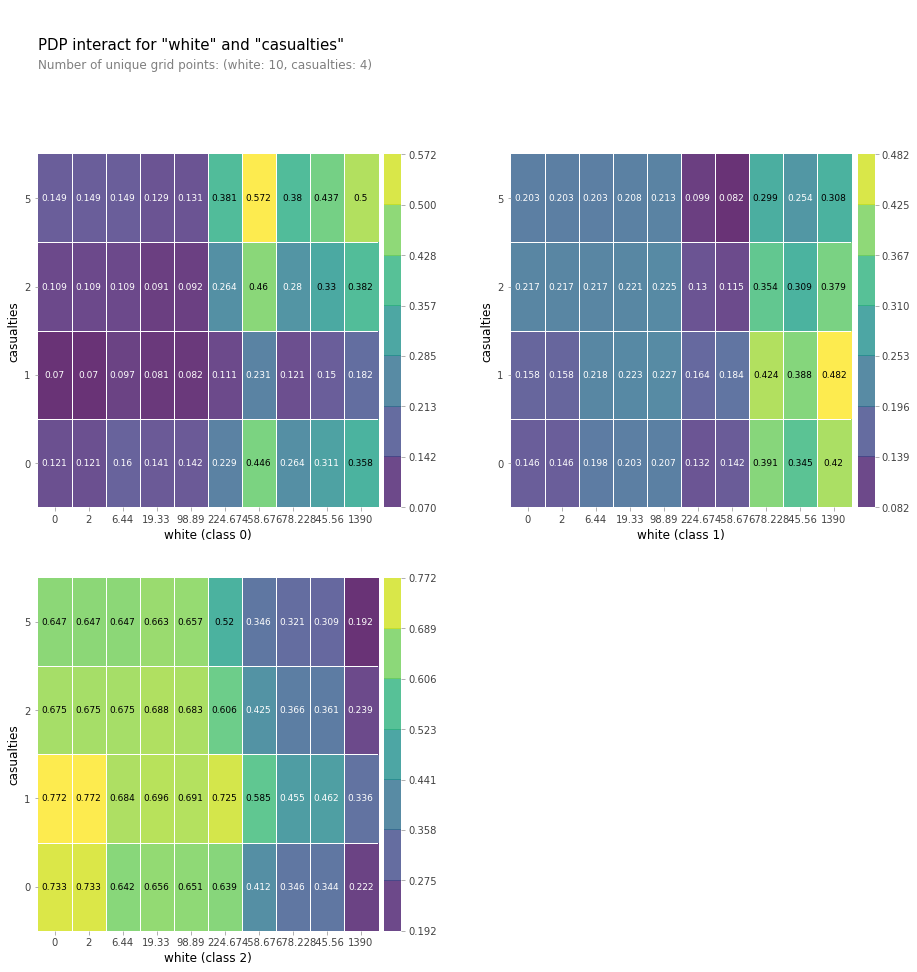

In [29]:
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

In [0]:
features = ['injured', 'casualties']

interaction = pdp_interact(
    model=pipeline, 
    dataset=X_test, 
    model_features=X_test.columns,
    features=features)

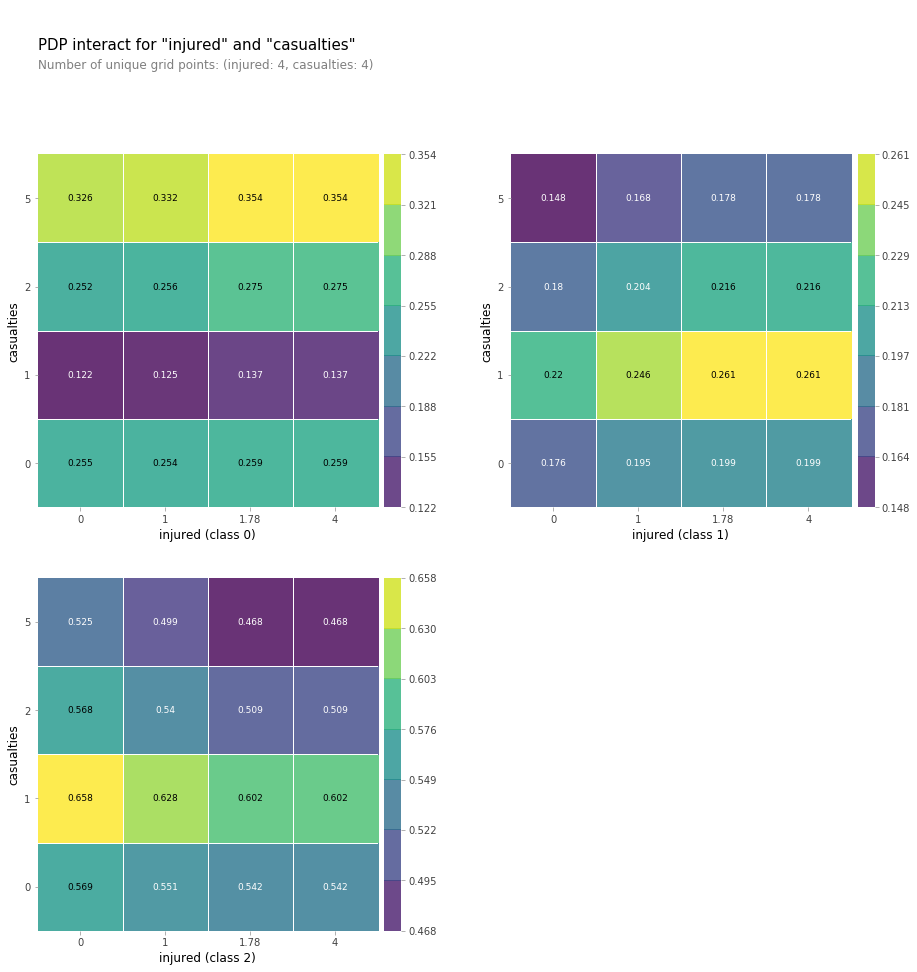

In [34]:
pdp_interact_plot(interaction, plot_type='grid', 
                  feature_names=features);

In [38]:
from scipy.stats import randint, uniform
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV

param_distributions = { 
    'n_estimators': randint(50, 500), 
    'max_depth': [5, 10, 15, 20, None], 
    'max_features': uniform(0, 1), 
}

search = RandomizedSearchCV(
    RandomForestClassifier(random_state=42), 
    param_distributions=param_distributions, 
    n_iter=10, 
    cv=3, 
    scoring='accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1, 
    random_state=42
)

search.fit(X_train_encoded, y_train);

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:    4.0s
[Parallel(n_jobs=-1)]: Done  21 tasks      | elapsed:    7.8s
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed:   10.9s finished


In [42]:
print('Best hyperparameters', search.best_params_)
print('Cross-validation MAE', search.best_score_)
model = search.best_estimator_

Best hyperparameters {'max_depth': 15, 'max_features': 0.020584494295802447, 'n_estimators': 307}
Cross-validation MAE 0.6158234126984127


In [0]:
# processor = make_pipeline(
#     ce.OrdinalEncoder())

# X_train_processed = processor.fit_transform(X_train)
# X_test_processed = processor.transform(X_test)

# eval_set = [(X_train_processed, y_train), 
#             (X_test_processed, y_test)]

# model = XGBClassifier(n_estimators=1000, n_jobs=-1)
# model.fit(X_train_processed, y_train, eval_set=eval_set, eval_metric='merror', 
#           early_stopping_rounds=10)

In [0]:
# row = X_test.iloc[[0]]
# row

In [0]:
# import shap

# explainer = shap.TreeExplainer(model)
# row_processed = processor.transform(row)
# shap_values = explainer.shap_values(row_processed)

# shap.initjs()
# shap.force_plot(
#     base_value=explainer.expected_value, 
#     shap_values=shap_values, 
#     features=row, 
#     link='logit' # For classification, this shows predicted probabilities
# )